# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [1]:
!pip install -q -r ../../requirements.txt &> /dev/null

In [2]:
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

import sys
sys.path.append('../..')
import helper_functions     # Own file.
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/information_filtering/trend_removal/models/../../helper_functions.py'>

## Data Loading & Preprocessing

In [3]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
# ds = xr.open_dataset("/kaggle/input/thermohaline-structure-of-the-medsea-01062m/medsea_monthly.nc")
print(ds.nbytes / 1e6, "MB")

z_temp = helper_functions.preprocessing(ds, ["thetao", "so"], [50, 300, 1000], "location", True, 1)
X = z_temp.values
input_dimension = X.shape[1]

print(z_temp.nbytes / 1e6, "MB")

20554.545012 MB
457.026912 MB


## Splitting

In [4]:
X = X.astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=27)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=32, shuffle=False)

## The Architecture

In [5]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(32, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


## Training Loop

In [6]:
def train(num_epochs: int):
    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            x = batch[0].to(device).float()
                    
            optimizer.zero_grad()
            x_recon = model(x)
            loss = loss_fn(x_recon, x)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)
    
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device).float()
                x_recon = model(x)
                loss = loss_fn(x_recon, x)
                running_val_loss += loss.item() * x.size(0)
    
        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses

## Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training using device: {device}')

model = Autoencoder(input_dim=input_dimension, latent_dim=3).to(device)
model = model.float()

summary(model, input_size=(1, X.shape[1],))

Training using device: cuda


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 167042]               --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 512]                  85,526,016
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 32]                   16,416
│    └─BatchNorm1d: 2-6                  [1, 32]                   64
│    └─Dropout: 2-7                      [1, 32]                   --
│    └─LeakyReLU: 2-8                    [1, 32]                   --
│    └─Linear: 2-9                       [1, 3]                    99
├─Sequential: 1-2                        [1, 167042]               --
│    └─Linear: 2-10                      [1, 32]                   128

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
num_epochs = 600
train_losses, val_losses = train(num_epochs)

Epoch 10/600 | Train Loss: 0.8117 | Val Loss: 0.8079
Epoch 20/600 | Train Loss: 0.7424 | Val Loss: 0.7489
Epoch 30/600 | Train Loss: 0.6896 | Val Loss: 0.7142
Epoch 40/600 | Train Loss: 0.6738 | Val Loss: 0.6944
Epoch 50/600 | Train Loss: 0.6608 | Val Loss: 0.6796
Epoch 60/600 | Train Loss: 0.6302 | Val Loss: 0.6699
Epoch 70/600 | Train Loss: 0.6289 | Val Loss: 0.6599
Epoch 80/600 | Train Loss: 0.6278 | Val Loss: 0.6524
Epoch 90/600 | Train Loss: 0.6033 | Val Loss: 0.6463
Epoch 100/600 | Train Loss: 0.5959 | Val Loss: 0.6422
Epoch 110/600 | Train Loss: 0.5969 | Val Loss: 0.6343
Epoch 120/600 | Train Loss: 0.5971 | Val Loss: 0.6280
Epoch 130/600 | Train Loss: 0.5719 | Val Loss: 0.6223
Epoch 140/600 | Train Loss: 0.5822 | Val Loss: 0.6190
Epoch 150/600 | Train Loss: 0.5702 | Val Loss: 0.6137
Epoch 160/600 | Train Loss: 0.5793 | Val Loss: 0.6095
Epoch 170/600 | Train Loss: 0.5663 | Val Loss: 0.6066
Epoch 180/600 | Train Loss: 0.5613 | Val Loss: 0.6068
Epoch 190/600 | Train Loss: 0.5725 | 

## Evaluation

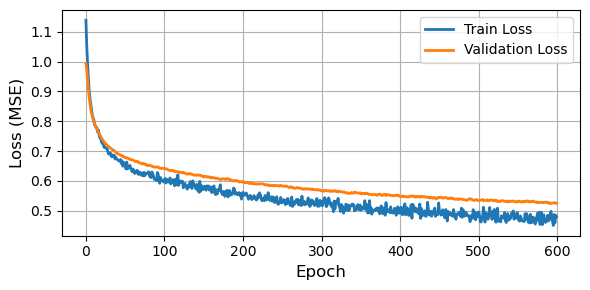

In [9]:
helper_functions.plot_metrics([(train_losses, "Train Loss"), (val_losses, "Validation Loss")], "Loss (MSE)")

In [10]:
torch.save(model.state_dict(), "AE.pth")